In [28]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#reading in files
df_2012 = pd.read_csv('database_miccai_2012_with_cat.csv')
df_2021 = pd.read_csv('database_miccai_2021_with_cat.csv')

In [3]:
#removing unnecessary index column
df_2012 = df_2012.drop("Unnamed: 0", axis = 1)
df_2021 = df_2021.drop("Unnamed: 0", axis = 1)

In [4]:
df_2012.head()

,Title,Authors,Page numbers,DOI,Year of publication,Part of publication,category
0,Reliable Assessment of Perfusivity and Diffusi...,"M. Freiman, S. D. Voss, R. V. Mulkern, J. M. P...",1-9,/chapter/10.1007/978-3-642-33415-3_1,2012.0,1,category: other
1,Multi-organ Abdominal CT Segmentation Using Hi...,"Robin Wolz, Chengwen Chu, Kazunari Misawa, Ken...",10-17,/chapter/10.1007/978-3-642-33415-3_2,2012.0,1,category: other
2,Radiation-Free Drill Guidance in Interlocking ...,"Benoit Diotte, Pascal Fallavollita, Lejing Wan...",18-25,/chapter/10.1007/978-3-642-33415-3_3,2012.0,1,category: unknown
3,Developing Essential Rigid-Flexible Outer Shea...,"Siyang Zuo, Takeshi Ohdaira, Kenta Kuwana, Yos...",26-33,/chapter/10.1007/978-3-642-33415-3_4,2012.0,1,category: unknown
4,Surgical Gesture Classification from Video Data,"Benjamín Béjar Haro, Luca Zappella, René Vidal",34-41,/chapter/10.1007/978-3-642-33415-3_5,2012.0,1,category: classification


In [5]:
#finding the references
def find_reference(year, place):
    reference_list = []
    with open(place, "r", encoding = 'utf-8') as part:
        article = part.read()
        if year == 2012:
            references = [i.start() for i in re.finditer("References\n\n1", article)]
            other_ref = [i.start() for i in re.finditer("References\n\n\[1\]", article)]
            all_ref = references + other_ref
            all_ref.sort()
            
        if year == 2021:
            all_ref = [i.start() for i in re.finditer("References", article)]
        for index in all_ref: 
            reference_list.append(article[index:index+8000])

    return reference_list


In [6]:
#saving the references
ref_list2012 = find_reference(2012, r"C:\Users\chris\Desktop\Value-Analysis-Thesis\combining proceedings txt\miccai_2012_full_txt.txt")
ref_list2021 = find_reference(2021, r"C:\Users\chris\Desktop\Value-Analysis-Thesis\combining proceedings txt\miccai_2021_full_txt.txt")

In [7]:
def create_ref_dic(ref_list):
    year={}
    i=0
    for element in ref_list:
        year[i] = []
        references = [i.start() for i in re.finditer("\([0-9][0-9][0-9][0-9]\)", element)]
        for index in references:
            num = element[index+1:index+5]
            if int(num) > 1850 and int(num) < 2023: #eliminating some mistakes with numbers that are clearly not years
                # 1852 is the oldest one that is actually correct - get a few 10xx and 11xx errors in both
                year.get(i).append(num)
        i+=1
    return year


In [8]:
def add_references(df, ref_list_all):
    
    
    row_list = df[df['category'] == 'category: classification'].index
    df_class = df[df['category'] == 'category: classification']
    
    ref_dic = create_ref_dic(ref_list_all)
    
    oldest_list = []
    newest_list = []
    range_list = []
    class_dic = {}
    num_ref = []

    for element in row_list:
        ref_dic.get(element).sort()
        class_dic[element] = ref_dic.get(element) #need this otherwise the sort is forgotten
        ref_list = class_dic.get(element)
        oldest_list.append(int(ref_list[0]))
        newest_list.append(int(ref_list[len(ref_list)-1]))
        range_list.append(int(ref_list[len(ref_list)-1])- int(ref_list[0]))
        num_ref.append(len(ref_list))
   
    
    data = {'index': row_list,
            'Number of references': num_ref,
            'Oldest reference': oldest_list,
            'Newest reference' : newest_list,
            'Range of references': range_list
    } 
    
    ref = pd.DataFrame(data)
    
    df_class = df_class.reset_index()
    
    df_class = df_class.merge(ref, on = 'index')
 
    
    return df_class 

    

In [9]:
df_2012class = add_references(df_2012, ref_list2012)

df_2021class = add_references(df_2021, ref_list2021)

## Calculating age of references

Testing out analysis of references, first calculating the age of the references: subtract age of reference from citing papers year of publication, 2012 or 2021

Not sure I'm going to need the add_references bit above.. eh - have been using it for finding the articles to annotate though!


In [10]:
dic2012 = create_ref_dic(ref_list2012)
dic2021 = create_ref_dic(ref_list2021)

In [11]:
#len(dic2021)
#df_2021class['Number of references'].sum()
df_2012class.describe()

,index,Year of publication,Part of publication,Number of references,Oldest reference,Newest reference,Range of references
count,90.000000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000
mean,125.922222,2012.0,1.966667,13.455556,1990.100000,2011.322222,21.222222
std,79.865509,0.0,0.853940,3.938177,14.852874,0.746946,14.750188
min,4.000000,2012.0,1.000000,5.000000,1912.000000,2008.000000,3.000000
25%,51.250000,2012.0,1.000000,10.250000,1986.250000,2011.000000,12.000000
50%,121.500000,2012.0,2.000000,12.000000,1994.000000,2011.000000,17.500000
75%,202.750000,2012.0,3.000000,16.000000,2000.000000,2012.000000,24.750000
max,248.000000,2012.0,3.000000,26.000000,2009.000000,2012.000000,99.000000


In [12]:
df_2021class.describe()

,index,Year of publication,Part of publication,Number of references,Oldest reference,Newest reference,Range of references
count,286.000000,286.0,286.000000,286.000000,286.000000,286.000000,286.000000
mean,308.307692,2021.0,5.202797,24.678322,1996.590909,2020.527972,23.937063
std,138.775837,0.0,2.057283,6.886143,18.270784,0.601974,18.295514
min,17.000000,2021.0,1.000000,9.000000,1852.000000,2017.000000,4.000000
25%,187.250000,2021.0,3.000000,20.000000,1992.000000,2020.000000,13.000000
50%,314.500000,2021.0,5.000000,25.000000,2001.000000,2021.000000,19.000000
75%,424.750000,2021.0,7.000000,29.000000,2008.000000,2021.000000,28.000000
max,529.000000,2021.0,8.000000,49.000000,2016.000000,2021.000000,168.000000


In [13]:
#method that updates the dictionary of index keys and ref list to contain tuples of ref year and age instead
#not used currently
def calc_age(dic, year):
    for key in dic.keys():
        ref_list = dic.get(key)
        with_age = []
        for ref in ref_list:
            with_age.append(year-int(ref))
        dic[key] = with_age
    return dic

In [14]:
#method that returns a single list of all the ages of the references in a given proceedings year
#only used currently for the below boxplot and double histogram
def age(dic, year):
    with_age = []
    for key in dic.keys():
        ref_list = dic.get(key)
        for ref in ref_list:
            age = year-int(ref)
            with_age.append(age)
    return with_age

## Section where I calculated mean, median, standard deviation for the age of references

In [15]:
age2012 = age(dic2012, 2012)
age2021 = age(dic2021, 2021)

In [26]:
import statistics

In [36]:
statistics.stdev(age2021)
#statistics.mean(age2012)
#statistics.median(age2012)

7.187819368945798

## Starting to plot!

In [68]:
#modified code from acl repo! Used to calculate/show the count of ages per year, looking for maxima
# Count citations by year & cited_age
#counts = df2012_with_year.groupby(['year', 'cited_age']).count()
counts = df2021_with_year.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"
#counts[counts['count'] == counts['count'].max()]

# Normalize by total no. of citations in year
#nfactor = df.groupby(['year']).count().reset_index()
#counts['count'] = counts['count'].astype(float)
#counts['percent_of_citations'] = counts.apply(lambda x: 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']), axis=1)


test = counts.sort_values(by = ['cited_age'], ascending = True)
test.head(50)

#sns.lineplot(data=counts, x='cited_age', y='count', hue='year', legend='full')

#plt.savefig('percent of citations vs age of citations')
#plt.show()


,year,cited_age,count
0,2021,0,551
1,2021,1,2450
2,2021,2,2244
3,2021,3,1699
4,2021,4,1475
5,2021,5,970
6,2021,6,769
7,2021,7,464
8,2021,8,320
9,2021,9,297


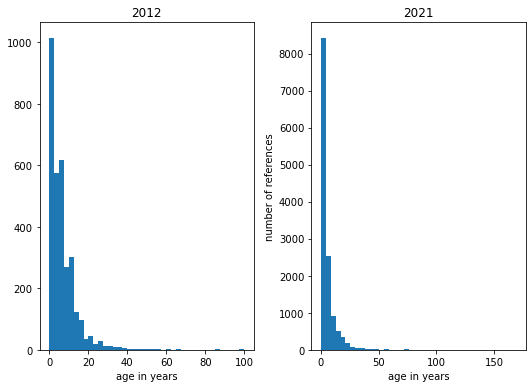

In [43]:
#creating two histograms - do want the y label to be on the far left side, but not shabby for now..
plt.rcParams["figure.figsize"] = [7.50, 5.50]
#plt.rcParams["figure.autolayout"] = True

data = {'2012': age(dic2012, 2012)}
data1 = {'2021': age(dic2021, 2021)}
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

ax0.hist(data.values(), bins = 40)
ax0.set_title('2012')
ax0.set_xlabel('age in years')

ax1.hist(data1.values(), bins = 40)
ax1.set_title('2021')
#ax1.set_ylabel('number of references')

#fig, ax = plt.subplots()
#ax.hist(data.values(), bins = 40)


#plt.title('ages of references')
plt.xlabel('age in years')
plt.ylabel('number of references')
plt.savefig('histograms of age')
plt.show()


In [37]:
#creating a df mimicking the one from the acl paper to be able to use their code for figures/analysis
#adding venues to get the acl code to work, not used as all texts are from miccai
def create_df(df, year, ref_dic):
    
    paper_id = df[df['category'] == 'category: classification'].index
    
    list_of_id = []
    list_of_year = []
    list_of_cited_age = []
    venue = []
    i = 0
    for key in ref_dic.keys():
        ref_list = ref_dic.get(key)
        for ref in ref_list:
            list_of_id.append(paper_id[i])
            list_of_year.append(year)
            list_of_cited_age.append(year-int(ref))
            venue.append('miccai')
        if i < 89:
            i = i+1
        
    data = {'paper_id': list_of_id,
            'venue': venue,
           'year': list_of_year,
           'cited_age': list_of_cited_age}
    df = pd.DataFrame.from_dict(data)
    
    return df

In [38]:
df2012_with_year = create_df(df_2012, 2012, dic2012)
df2021_with_year = create_df(df_2021, 2021, dic2021)

df = pd.concat([df2012_with_year, df2021_with_year],    # Combine vertically
                          ignore_index = True,
                          sort = False)

#creating a df of paper id (for every row corresponding to citations), year of proceedings and cited age as columns

## Code from here on down is mostly from acl repo!

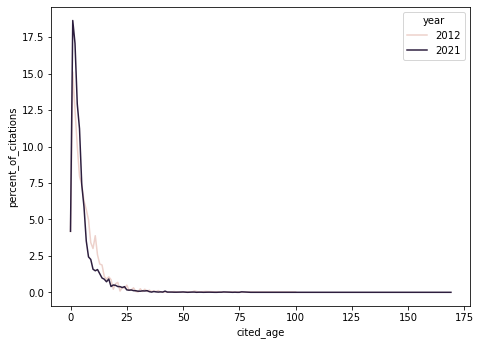

In [40]:
#code from acl repo! 
# Count citations by year & cited_age
counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"


# Normalize by total no. of citations in year
nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
counts['percent_of_citations'] = counts.apply(lambda x: 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']), axis=1)


sns.lineplot(data=counts, x='cited_age', y='percent_of_citations', hue='year', legend='full')


plt.savefig('percent of citations vs age of citations')

(array([0, 1]), [Text(0, 0, '2012'), Text(1, 0, '2021')])

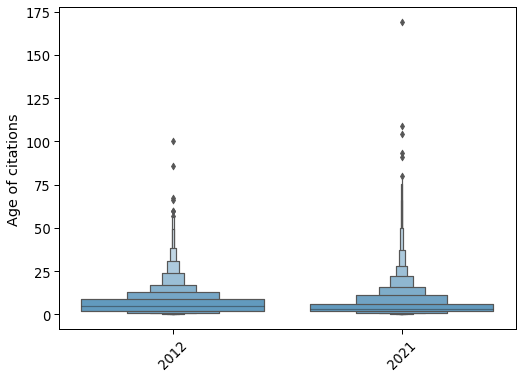

In [39]:
#looks very squished but works!
#acl code!
sns.set_context("paper", font_scale=1.5)
ax = sns.boxenplot(data=df, x='year', y='cited_age', palette=[sns.color_palette("Blues")[3]])

ax.set_xlabel("")
ax.set_ylabel("Age of citations")
plt.xticks(rotation=45)

<AxesSubplot:xlabel='cited_age', ylabel='cumcount'>

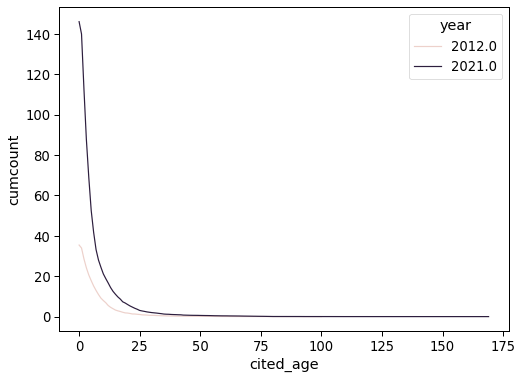

In [41]:
#acl code
# normalize by total no. of *papers* in year
pfactor = df['paper_id'].groupby(df['year']).nunique('paper_id').reset_index()
counts['count'] = counts['count'].astype(float)
pcounts = counts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id']), x[3]], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
pcounts = pcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
pcounts['cumcount'] = pcounts.groupby('year')['count'].transform(pd.Series.cumsum)

sns.lineplot(data=pcounts, x='cited_age', y='cumcount', hue='year', legend='full')



The graph above shows the average number of citations per paper that are X or more years old. (copied from acl)

In [42]:
#acl code - can definitely see that that one paper from 1872(?) is insanely skewing things
#wait no, this makes no sense? Not sure this is correct at all?

#We can sanity-check that this calculation is correct by directly calculating the average number of citations per paper:

# no. of citations per paper
cpp = df.groupby(['paper_id', 'year']).count()['cited_age'].reset_index()
# mean by year
cpp.groupby('year').mean()

,paper_id,cited_age
year,,
2012,125.922222,35.444444
2021,137.600000,146.044444


Tried the fancy one with stacked years, but didn't copy over and work... So will leave that work for later! - fig 4
now for fig 8:

Oldest citation per paper
The following plot considers only the distribution of the oldest citation per publication:

(array([0, 1]), [Text(0, 0, '2012'), Text(1, 0, '2021')])

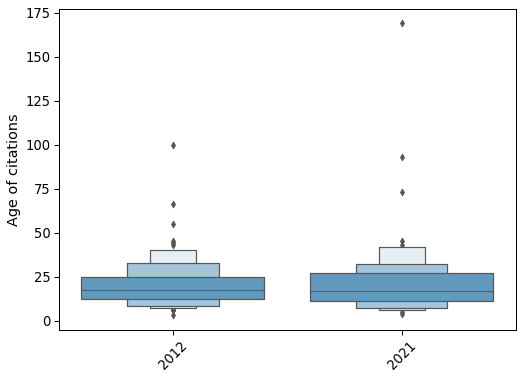

In [49]:
#acl code
df_max = df.groupby(['paper_id', 'year'])["cited_age"].max().reset_index()
sns.set_context("paper", font_scale=1.5)
ax = sns.boxenplot(data=df_max, x='year', y='cited_age', palette=[sns.color_palette("Blues")[3]])

ax.set_xlabel("")
ax.set_ylabel("Age of citations")
plt.xticks(rotation=45)


In [9]:
pd.set_option('display.max_rows', None)

In [9]:
#saving updated database to csv
df_2012class.to_csv("database_miccai_2012_with_ref.csv")
df_2021class.to_csv("database_miccai_2021_with_ref.csv")

In [10]:
df_2021class[df_2021class['Part of publication']==5]

,index,Title,Authors,Page numbers,DOI,Year of publication,Part of publication,category,Number of references,Oldest reference,Newest reference,Range of references
94,255,CA-Net: Leveraging Contextual Features for Lun...,"Mingzhou Liu, Fandong Zhang, Xinwei Sun, Yizho...",23-32,/chapter/10.1007/978-3-030-87240-3_3,2021,5,category: classification,22,1991,2020,29
95,257,DAE-GCN: Identifying Disease-Related Features ...,"Churan Wang, Xinwei Sun, Fandong Zhang, Yizhou...",43-52,/chapter/10.1007/978-3-030-87240-3_5,2021,5,category: classification,14,1996,2020,24
96,258,Enhanced Breast Lesion Classification via Know...,"Kun Chen, Yuanfan Guo, Canqian Yang, Yi Xu, Ru...",53-63,/chapter/10.1007/978-3-030-87240-3_6,2021,5,category: classification,29,2003,2021,18
97,259,Multiple Meta-model Quantifying for Medical Vi...,"Tuong Do, Binh X. Nguyen, Erman Tjiputra, Minh...",64-74,/chapter/10.1007/978-3-030-87240-3_7,2021,5,category: classification,45,1987,2021,34
98,262,A Coherent Cooperative Learning Framework Base...,"Xinxin Shan, Ying Wen, Qingli Li, Yue Lu, Haib...",96-106,/chapter/10.1007/978-3-030-87240-3_10,2021,5,category: classification,35,2010,2020,10
99,264,A Segmentation-Assisted Model for Universal Le...,"Fei Lyu, Baoyao Yang, Andy J. Ma, Pong C. Yuen",117-127,/chapter/10.1007/978-3-030-87240-3_12,2021,5,category: classification,22,2009,2020,11
100,265,Constrained Contrastive Distribution Learning ...,"Yu Tian, Guansong Pang, Fengbei Liu, Yuanhong ...",128-140,/chapter/10.1007/978-3-030-87240-3_13,2021,5,category: classification,41,1999,2021,22
101,266,Conditional Training with Bounding Map for Uni...,"Han Li, Long Chen, Hu Han, Ying Chi, S. Kevin ...",141-152,/chapter/10.1007/978-3-030-87240-3_14,2021,5,category: classification,35,2015,2021,6
102,267,Focusing on Clinically Interpretable Features:...,"Chong Yin, Siqi Liu, Rui Shao, Pong C. Yuen",153-162,/chapter/10.1007/978-3-030-87240-3_15,2021,5,category: classification,26,2005,2020,15
103,268,Categorical Relation-Preserving Contrastive Kn...,"Xiaohan Xing, Yuenan Hou, Hang Li, Yixuan Yuan...",163-173,/chapter/10.1007/978-3-030-87240-3_16,2021,5,category: classification,29,2014,2020,6


In [14]:
df_2012class.tail(40)

,index,Title,Authors,Page numbers,DOI,Year of publication,Part of publication,category,Number of references,Oldest reference,Newest reference,Range of references
50,137,Hierarchical Conditional Random Fields for Det...,"Zahra Karimaghaloo, Douglas L. Arnold, D. Loui...",379-386,/chapter/10.1007/978-3-642-33418-4_47,2012.0,2,category: classification,10,1997,2012,15
51,150,Hemodynamic Assessment of Pre- and Post-operat...,"Kristóf Ralovich, Lucian Itu, Viorel Mihalef, ...",486-493,/chapter/10.1007/978-3-642-33418-4_60,2012.0,2,category: classification,17,1989,2011,22
52,152,Morphological Analysis of the Left Ventricular...,"Anirban Mukhopadhyay, Zhen Qian, Suchendra M. ...",502-510,/chapter/10.1007/978-3-642-33418-4_62,2012.0,2,category: classification,16,1987,2011,24
53,153,Prior-Based Automatic Segmentation of the Caro...,"Jana Hutter, Hannes G. Hofmann, Robert Grimm, ...",511-518,/chapter/10.1007/978-3-642-33418-4_63,2012.0,2,category: classification,16,1991,2011,20
54,154,A Convex Relaxation Approach to Fat/Water Sepa...,"Abraam S. Soliman, Jing Yuan, James A. White, ...",519-526,/chapter/10.1007/978-3-642-33418-4_64,2012.0,2,category: classification,17,2004,2012,8
55,157,Ultrasound and Fluoroscopic Images Fusion by A...,"Peter Mountney, Razvan Ionasec, Markus Kaizer,...",544-551,/chapter/10.1007/978-3-642-33418-4_67,2012.0,2,category: classification,9,2009,2012,3
56,162,Semi-automatic Catheter Reconstruction from Tw...,"Matthias Hoffmann, Alexander Brost, Carolin Ja...",584-591,/chapter/10.1007/978-3-642-33418-4_72,2012.0,2,category: classification,10,1997,2011,14
57,163,Feature Classification for Tracking Articulate...,"Austin Reiter, Peter K. Allen, Tao Zhao",592-600,/chapter/10.1007/978-3-642-33418-4_73,2012.0,2,category: classification,19,1994,2012,18
58,169,Registration Accuracy: How Good Is Good Enough...,"Eli Gibson, Aaron Fenster, Aaron D. Ward",643-650,/chapter/10.1007/978-3-642-33418-4_79,2012.0,2,category: classification,5,1995,2011,16
59,174,Parametric Dictionary Learning for Modeling EA...,"Sylvain Merlet, Emmanuel Caruyer, Rachid Deriche",10-17,/chapter/10.1007/978-3-642-33454-2_2,2012.0,3,category: classification,10,2006,2011,5
